# Business Requirement:

So this week we are looking at a problem in ***cybersecurity.*** We're dealing with a big company here that has a lot of firewall interaction. Now what they're asking us to do is to build a program about whether or not to accept or deny access to requests coming in.

They want us to automate it because, currently, their current system is taking up a lot of manpower and a lot of resources. So they have all the ***historical data** from before of how they've chosen to accept and deny these requests. So the model needs to be able to filter the incoming requests.

We need to classify them. And then it needs to be able to auto accept or auto deny the request. We want the best, most advanced model. It needs to be accurate, and it needs to function at speed.

So you have about ***60,000 rows*** of data to play with. And in the end, whether we put this model together, we're going to need a report on the level of accuracy and the level of performance so that they can make the decision on whether or not this can be implemented. 

***Build firewall classification model to classify whether or not to accept or deny access to requests coming in***

In [3]:
# To supress warnings
import warnings
warnings.filterwarnings("ignore")

#for data
import pandas as pd 
import numpy as np 

# scikit-learn's SimpleImputer to replace "nan" values
from sklearn.impute import SimpleImputer

# Display all columns 
pd.options.display.max_columns = None
## for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from yellowbrick.classifier import ClassificationReport

#Xgboost
import xgboost as xgb

# RandomForest
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score

import time
import os
# For loading .arff files
from scipy.io import arff
import urllib.request
import io # for io.StringIO()
import copy
# To analyze the type of missing data
import missingno as msno


In [1]:
data = 'https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy5/log2.csv'
df = pd.read_csv('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy5/log2.csv')

In [5]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [9]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [12]:
df.isna().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [16]:
# print the number of records and attributes in the dataframe
records = len(df)
attributes = df.columns
print(f'Total Number of Records: {records} \nTotal Number of Attributes: {len(attributes)}')

Total Number of Records: 65532 
Total Number of Attributes: 12


In [17]:
def checkDuplicate (df):
    df_duplicates = df.groupby(df.columns.tolist(),as_index=False).size()
    duplicates = len(df_duplicates.loc[df_duplicates['size'] > 1])
    if duplicates == 0:
        print('NO, duplicate instances are not present')
    else:
        print('Yes, duplicate instances are present')
# lets check if duplicate instances are present
dup_result = checkDuplicate(df)

Yes, duplicate instances are present


Duplicates are calculated based on Source Port. There are Source Port with similar numbers. 

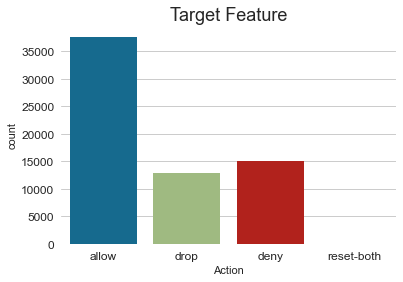

In [32]:
sns.countplot(x='Action',data=df) 
plt.title('Target Feature',size=18)
plt.rcParams['axes.spines.right']=False # remove the plot border
plt.rcParams['axes.spines.left']=False # remove the plot border
plt.rcParams['axes.spines.top']=False # remove the plot border
plt.rcParams['axes.spines.bottom']=False # remove the plot border
plt.xticks(size=12)
plt.yticks(size=12) 
plt.show()

In [33]:
# Is this a multi-class problem? 
df['Action'].value_counts()

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

In [37]:
df['Bytes Sent'].value_counts()

70        11015
66         9494
62         5679
94         3904
102        3519
          ...  
7524          1
243           1
12533         1
26878         1
344312        1
Name: Bytes Sent, Length: 6683, dtype: int64

In [35]:
df.head(2)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
